# Manns Lab Data integration 

This notebook explores the differences in the PILOT and MAIN datasets, and how to integrate these datasets for further analysis.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr
import warnings

import manns_lab_support as sup
import scp.utils as utils

warnings.filterwarnings("ignore")

np.random.seed(0)

## Data loading

In [2]:
MAIN_DIR = "../data/manns_lab/MAIN/"
PILOT_DIR = "../data/manns_lab/PILOT/"

Let"s load the data.

In [3]:
main_adata = sup.load_main_data(MAIN_DIR)
main_adata = sup.preprocess(main_adata)

preprocess input: (5045, 2703)
sc.pp.filter_genes: (5045, 2703)
sc.pp.filter_cells: (5045, 2703)
filter: (4566, 2018)


In [4]:
pilot_adata = sup.load_pilot_data(PILOT_DIR)
pilot_adata = sup.preprocess(pilot_adata)

pilot_adata = utils.reshape_anndata_like(adata=pilot_adata, adata_like=main_adata)

preprocess input: (461, 3306)
sc.pp.filter_genes: (461, 3305)
sc.pp.filter_cells: (461, 3305)
filter: (454, 2963)
transfering 447 cells and 1783 proteins during reshape.


In [5]:
x_step = utils.fill_if_nan(main_adata.X, pilot_adata.X)

In [6]:
print(f"pilot intensity coverage:    {utils.get_coverage(pilot_adata.X):.2%}")
print(f"main intensity coverage:     {utils.get_coverage(main_adata.X):.2%}")
print(f"combined intensity coverage: {utils.get_coverage(x_step):.2%}")

pilot intensity coverage:    7.47%
main intensity coverage:     69.66%
combined intensity coverage: 71.28%


Let's do the correction.

In [7]:
main_adata.layers["raw"] = main_adata.X.copy()

sup.correct_batch(main_adata)
main_adata.layers["corrected"] = main_adata.X.copy()

In [8]:
pilot_adata.layers["raw"] = pilot_adata.X.copy()

sup.correct_batch(pilot_adata)
pilot_adata.layers["corrected"] = pilot_adata.X.copy()

In [9]:
x_step = utils.fill_if_nan(main_adata.X, pilot_adata.X)

In [10]:
print(f"pilot intensity coverage:    {utils.get_coverage(pilot_adata.X):.2%}")
print(f"main intensity coverage:     {utils.get_coverage(main_adata.X):.2%}")
print(f"combined intensity coverage: {utils.get_coverage(x_step):.2%}")

pilot intensity coverage:    7.47%
main intensity coverage:     69.66%
combined intensity coverage: 71.28%


## Data exploration

### Overview

In [11]:
overlap_mask = np.logical_and(~np.isnan(pilot_adata.layers["raw"]), ~np.isnan(main_adata.layers["raw"]))

n_overlap = np.sum(overlap_mask)

print(f"Number of overlapping intensities: {n_overlap}")
print(f"Number of patients with overlapping intensities: {np.sum(np.any(overlap_mask, axis=1))}")
print(f"Number of proteins with overlapping intensities: {np.sum(np.any(overlap_mask, axis=0))}")

Number of overlapping intensities: 539467
Number of patients with overlapping intensities: 447
Number of proteins with overlapping intensities: 1783


In [12]:
overlap_mask = ~np.isnan(pilot_adata.X) & ~np.isnan(main_adata.X)
row_idx, col_idx = np.where(overlap_mask)

Text(619.9949494949494, 0.5, 'PILOT intensity')

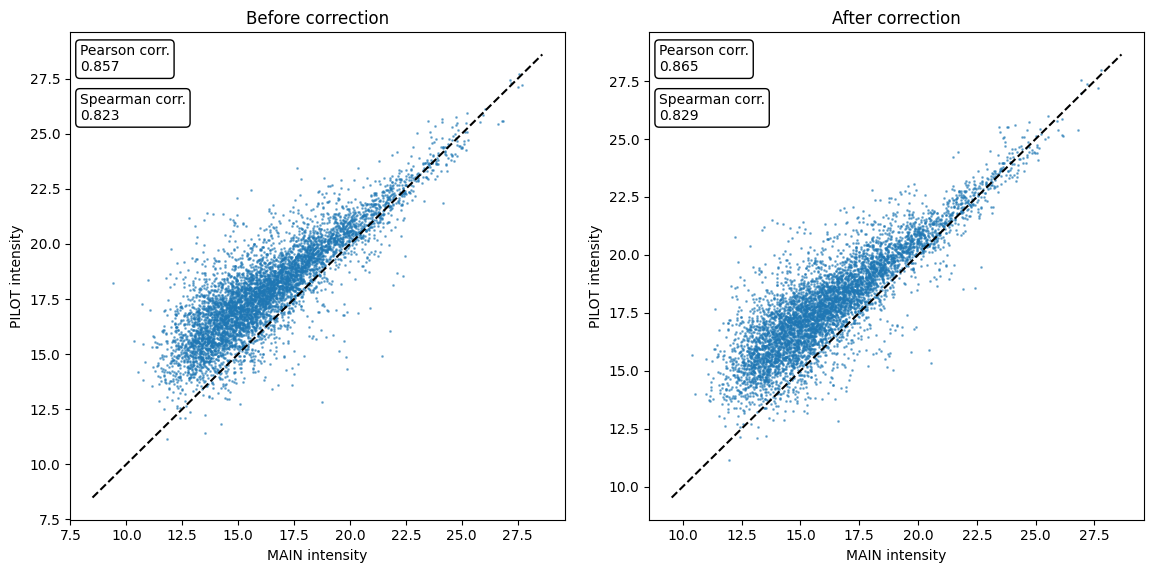

In [13]:
n = 6_000
idx = np.random.choice(n_overlap, n, replace=False)

fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
fig.tight_layout(pad=3)

# before batch correction
ax = axes[0]

x1 = pilot_adata.layers["raw"][row_idx[idx], col_idx[idx]]
x2 = main_adata.layers["raw"][row_idx[idx], col_idx[idx]]

pearson = pearsonr(x1, x2)
ax.text(0.02, 0.92, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

spearman = spearmanr(x1, x2)
ax.text(0.02, 0.82, f"Spearman corr.\n{spearman[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.scatter(x2, x1, s=1, alpha=0.5)
x_step = np.linspace(*ax.get_xlim())
ax.plot(x_step, x_step, color="black", linestyle="--")
ax.set_title(f"Before correction")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

# after batch correction
ax = axes[1]

x1 = pilot_adata.layers["corrected"][row_idx[idx], col_idx[idx]]
x2 = main_adata.layers["corrected"][row_idx[idx], col_idx[idx]]

pearson = pearsonr(x1, x2)
ax.text(0.02, 0.92, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

spearman = spearmanr(x1, x2)
ax.text(0.02, 0.82, f"Spearman corr.\n{spearman[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.scatter(x2, x1, s=1, alpha=0.5)
x_step = np.linspace(*ax.get_xlim())
ax.plot(x_step, x_step, color="black", linestyle="--")
ax.set_title(f"After correction")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

### Correlation between intensity differences and continuous patient-level metadata

In [14]:
def plot_continous_annotation_difference(adata1, adata2, continous_annotation, idx, use_annotation_difference=False, ax=None):
    overlap_mask = ~np.isnan(adata1.X) & ~np.isnan(adata2.X)

    row_idx, col_idx = np.where(overlap_mask)

    x1 = adata1.X[row_idx[idx], col_idx[idx]]
    x2 = adata2.X[row_idx[idx], col_idx[idx]]

    x_diff = x1 - x2

    if use_annotation_difference:
        annotation_diff = adata1.obs[continous_annotation].values[row_idx[idx]] - adata2.obs[continous_annotation].values[row_idx[idx]]
        y_label = f"{continous_annotation} difference"
        title = f"{continous_annotation} difference vs. intensity diff"
    else:
        annotation_diff = adata1.obs[continous_annotation].values[row_idx[idx]]
        y_label = continous_annotation
        title = f"{continous_annotation} vs. intensity diff"

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    
    ax.scatter(x_diff, annotation_diff, s=5, alpha=0.5)
    ax.set_xlabel("intensity difference")
    ax.set_ylabel(y_label)
    ax.set_title(title)

In [15]:
n = 6_000
idx = np.random.choice(n_overlap, n, replace=False)

continous_annotations = [
    "Age", "Qalb", "FWHM.Scans", "FWHM.RT", "n_genes", "Total protein", "MS2.Signal", "Leukocyte count", 
    "Median.Mass.Acc.MS2", "Median.Mass.Acc.MS1.Corrected", "Normalisation.Instability", "Precursors.Identified",
    "Median.RT.Prediction.Acc", "Average.Peptide.Length"
]

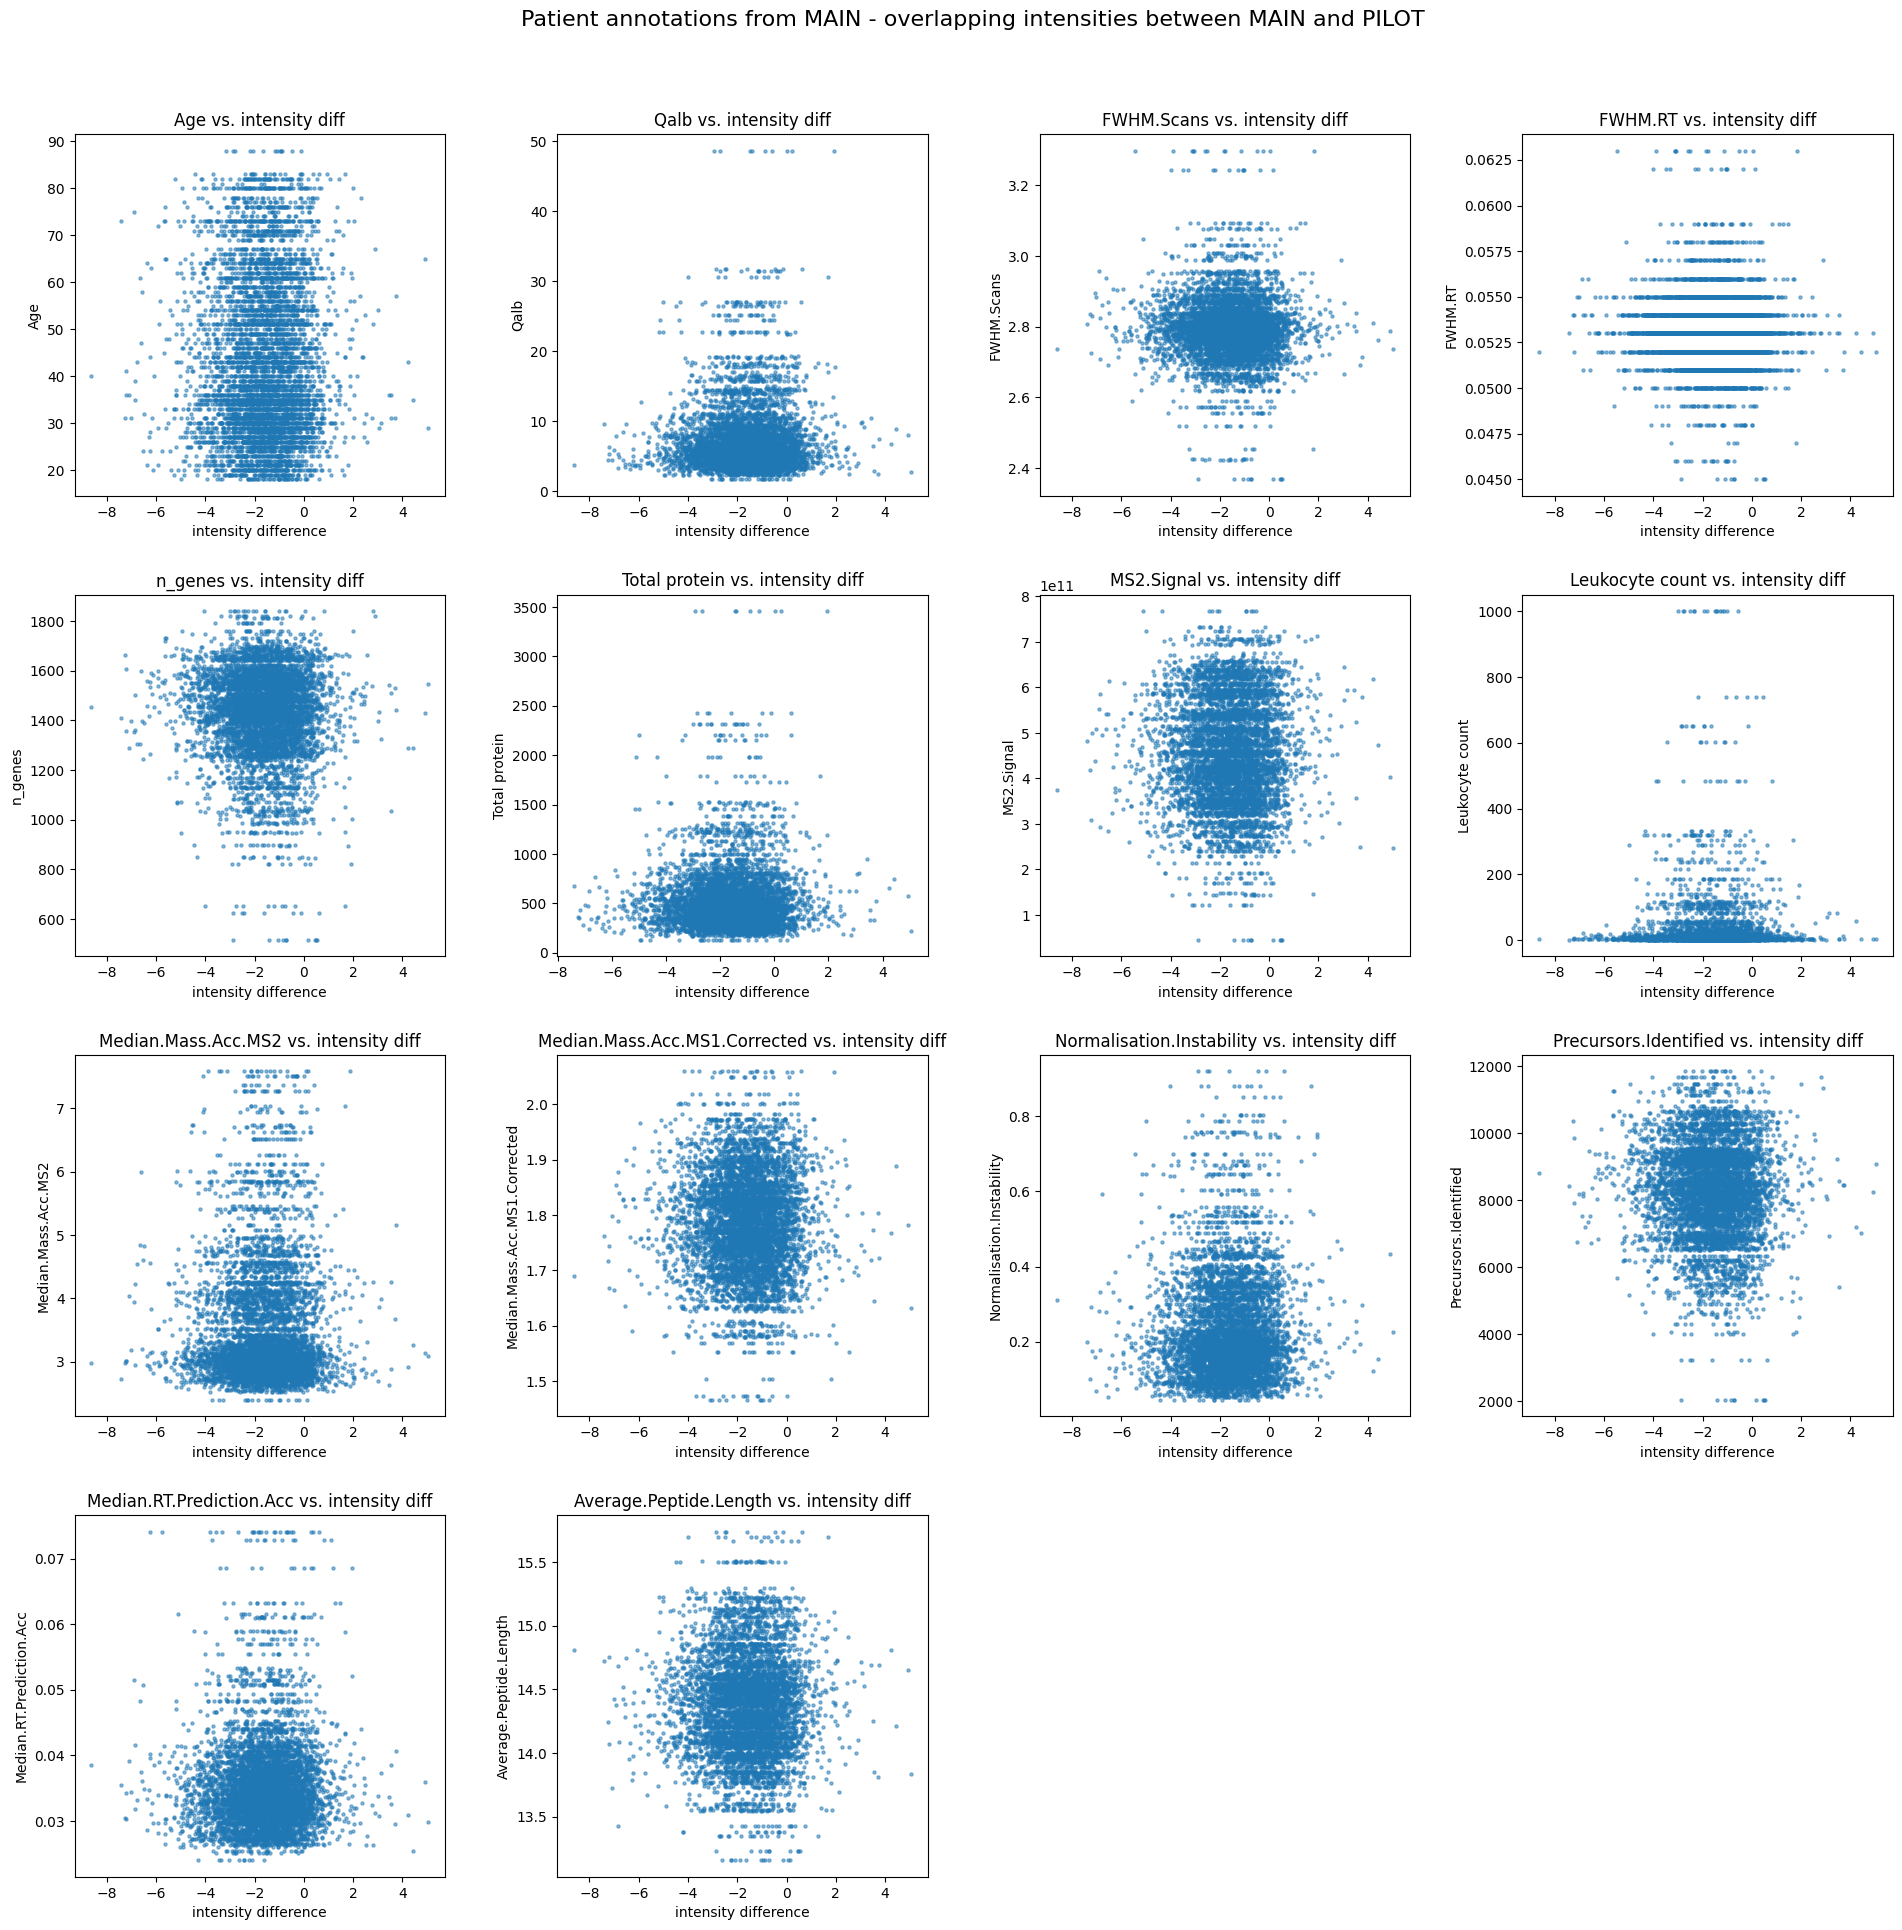

In [16]:
max_cols = 4
n_annotations = len(continous_annotations)

n_cols = min(max_cols, n_annotations)
n_rows = n_annotations // n_cols + (n_annotations % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle("Patient annotations from MAIN - overlapping intensities between MAIN and PILOT", fontsize=16)
fig.tight_layout(pad=5.0)

for i, annotation in enumerate(continous_annotations):
    ax = axes[i] if n_rows == 1 else axes[i // n_cols, i % n_cols]
    plot_continous_annotation_difference(main_adata, pilot_adata, annotation, idx, ax=ax)

for i in range(n_annotations, n_rows * n_cols):
    axes[i // n_cols, i % n_cols].axis("off")

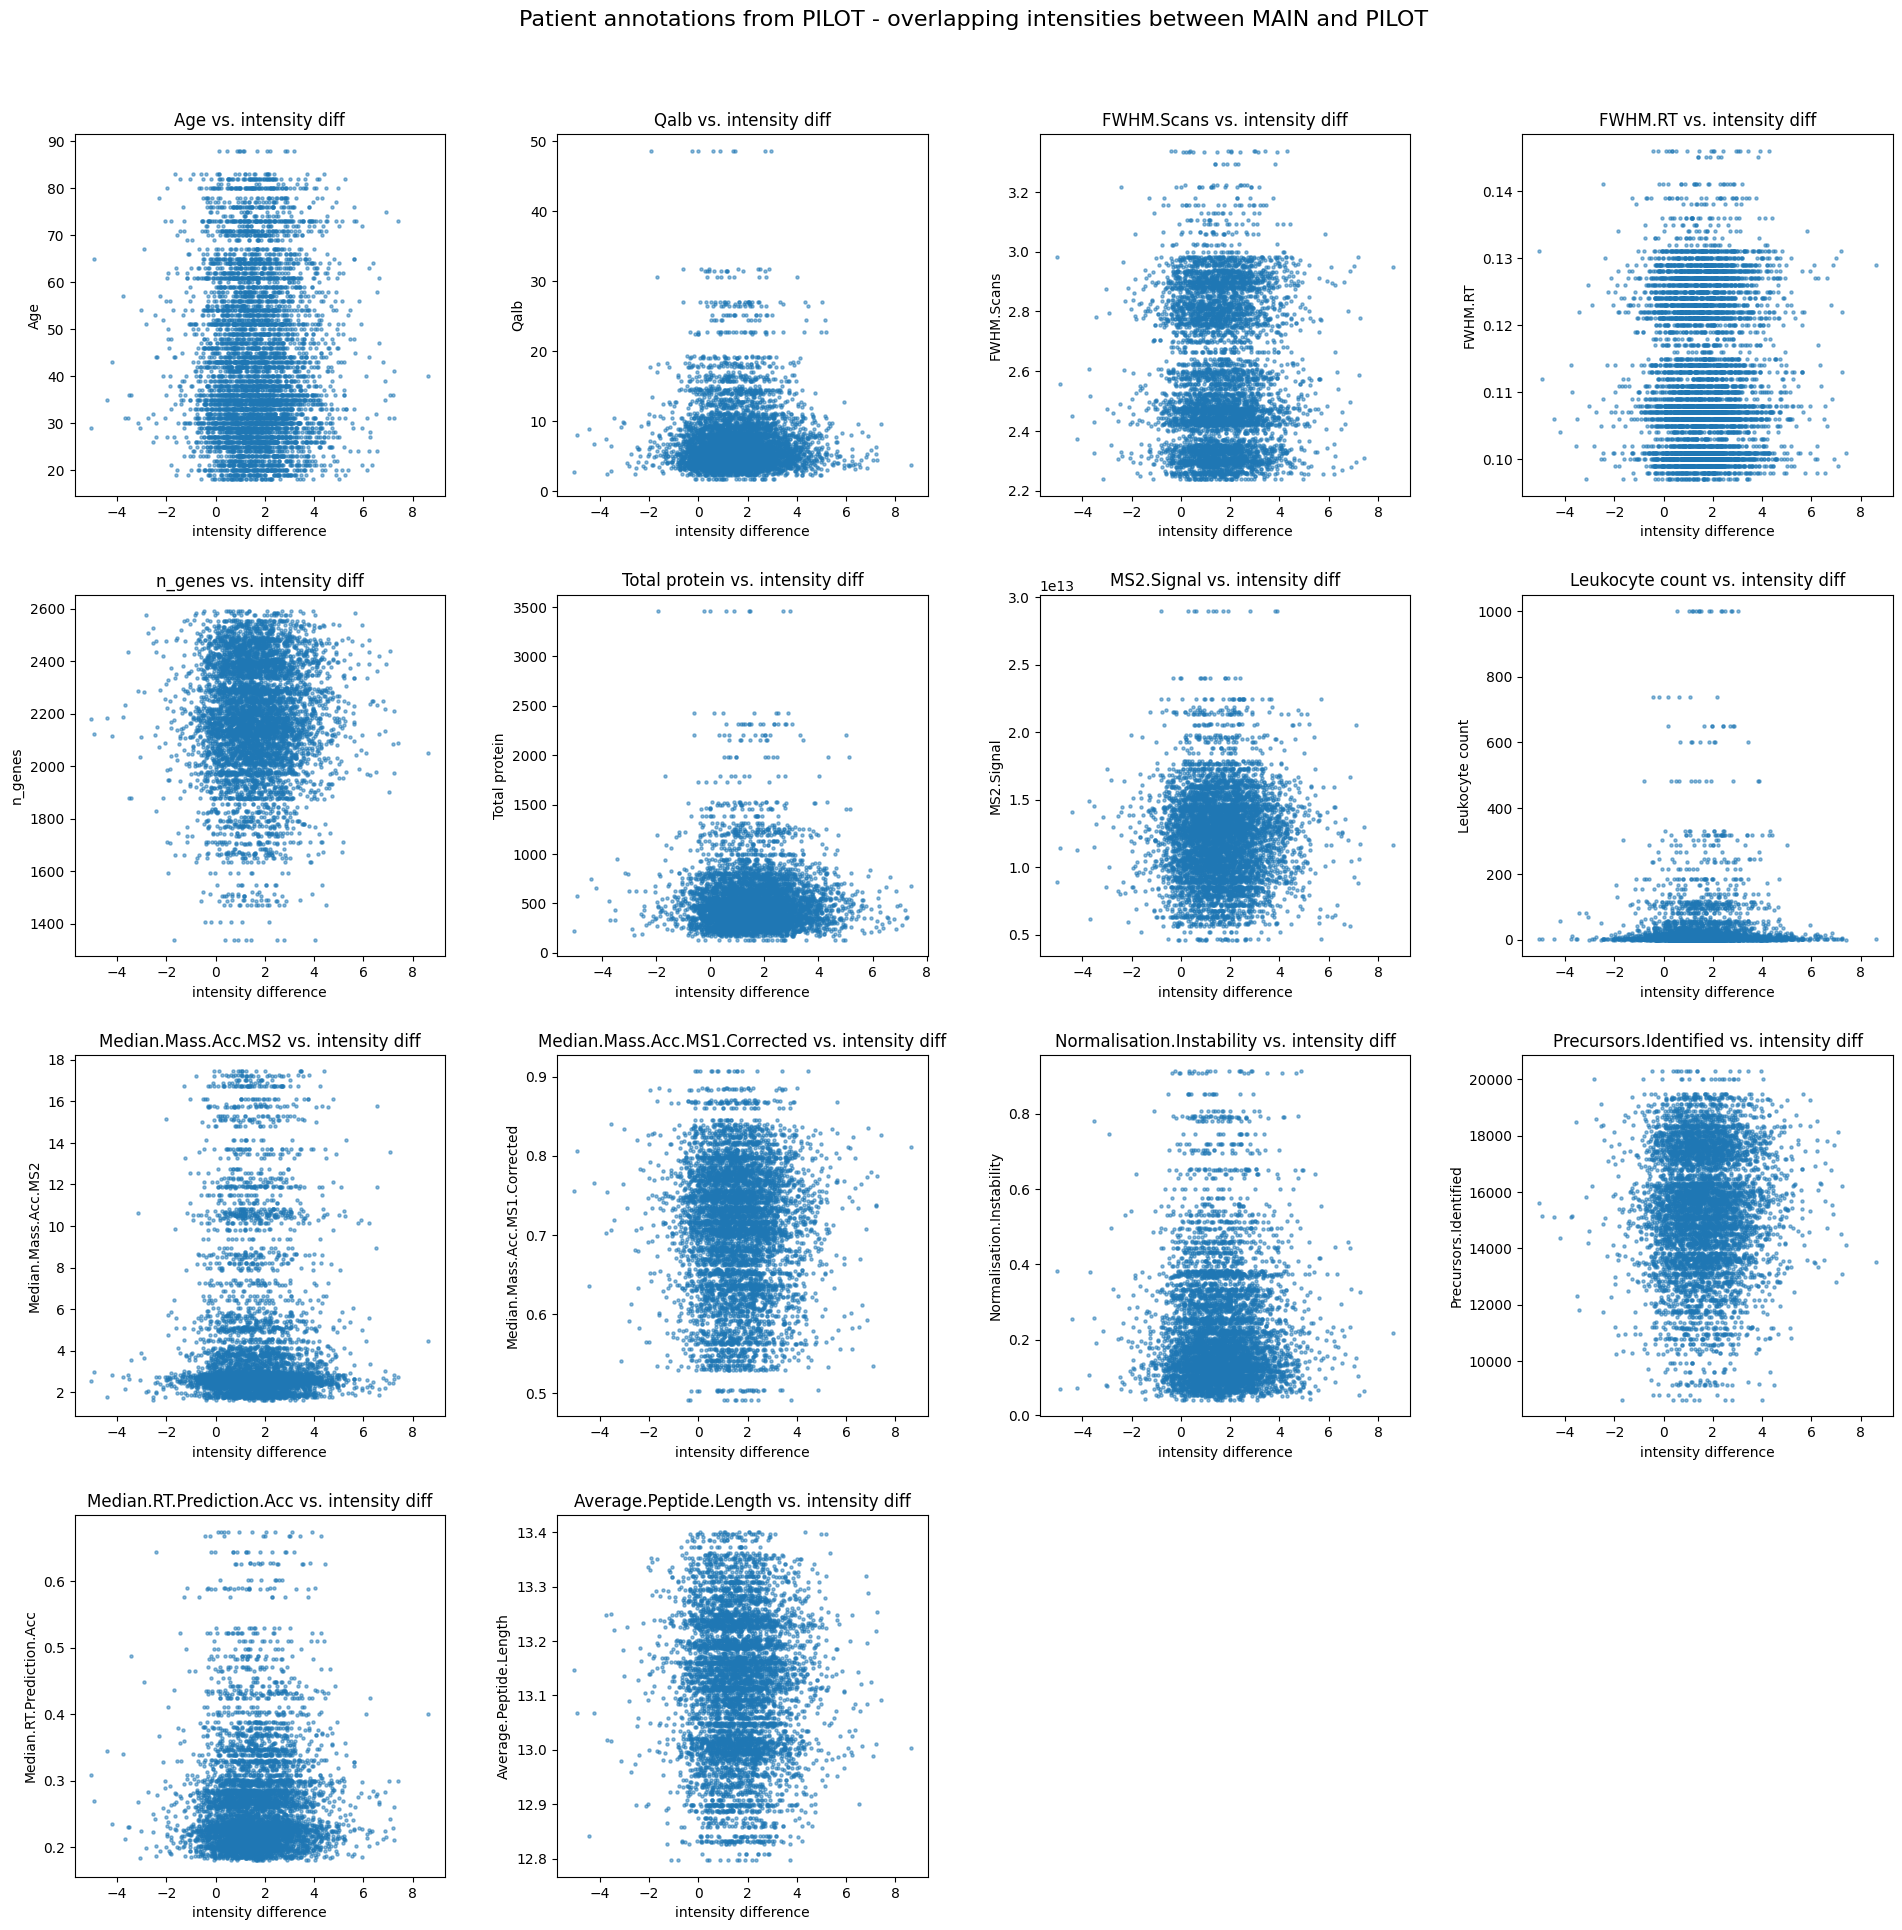

In [17]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle("Patient annotations from PILOT - overlapping intensities between MAIN and PILOT", fontsize=16)
fig.tight_layout(pad=5.0)

for i, annotation in enumerate(continous_annotations):
    ax = axes[i] if n_rows == 1 else axes[i // n_cols, i % n_cols]
    plot_continous_annotation_difference(pilot_adata, main_adata, annotation, idx, ax=ax)

for i in range(n_annotations, n_rows * n_cols):
    axes[i // n_cols, i % n_cols].axis("off")

### Scatter plots of overlapping intensities filtered by patient annotation

In [18]:
def plot_categorial_annotation_scatter(adata1, adata2, category_annotation, title=None, ax=None):
    x1 = adata1.X
    x2 = adata2.X

    category_annotation = "Diagnosis_group"
    categories = np.unique(adata1.obs[category_annotation].values)

    max_cols = 8
    n_annotations = len(categories)

    n_cols = min(max_cols, n_annotations)
    n_rows = n_annotations // n_cols + (n_annotations % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    title = title if title is not None else f"{category_annotation} - overlapping intensities between MAIN and PILOT"
    fig.suptitle(title)
    fig.tight_layout(pad=3.0)

    for i, annotation in enumerate(categories):
        ax = axes[i] if n_rows == 1 else axes[i // n_cols, i % n_cols]

        category_mask = (adata1.obs[category_annotation].values == annotation).reshape(-1, 1)
        mask = overlap_mask & category_mask

        x1_mask = x1[mask]
        x2_mask = x2[mask]

        ax.scatter(x1_mask, x2_mask, s=2, alpha=1)

        x_step = np.linspace(*ax.get_xlim())
        ax.plot(x_step, x_step, color="black", linestyle="--")

        if x1_mask.size >= 2:
            pearson = pearsonr(x1_mask, x2_mask)
            ax.text(0.04, 0.88, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

        ax.set_xlabel("MAIN intensity")
        ax.set_ylabel("PILOT intensity")
        ax.set_title(annotation)


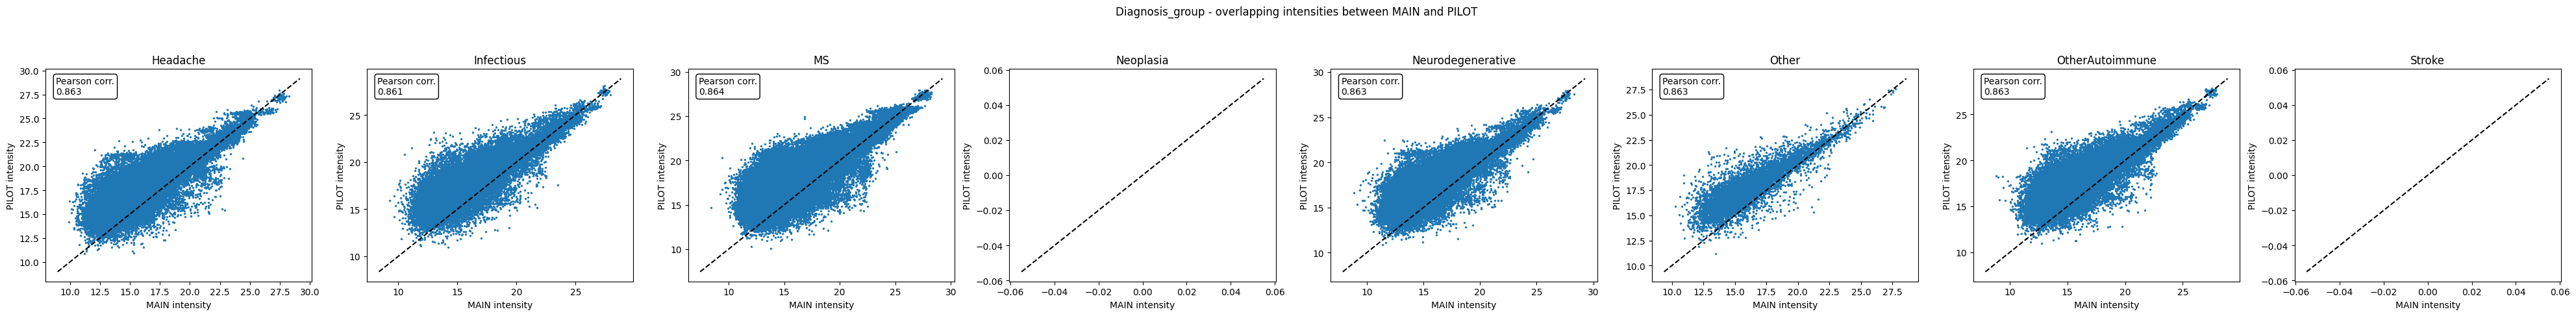

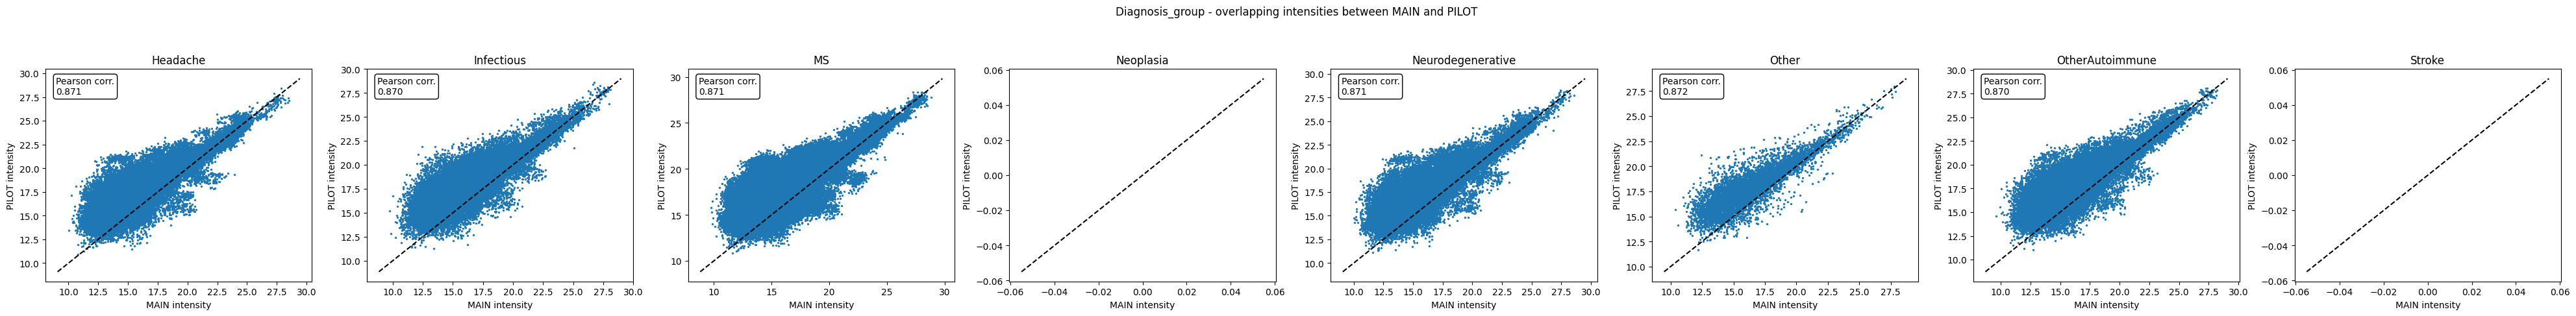

In [19]:
main_adata.X = main_adata.layers["raw"]
pilot_adata.X = pilot_adata.layers["raw"]
plot_categorial_annotation_scatter(main_adata, pilot_adata, "Diagnosis_group")

main_adata.X = main_adata.layers["corrected"]
pilot_adata.X = pilot_adata.layers["corrected"]
plot_categorial_annotation_scatter(main_adata, pilot_adata, "Diagnosis_group")

### Histogram of correlations between overlapping intensities

In [20]:
def compute_overlapping_protein_correlation(x1, x2, metrics=["pearson", "spearman"]):
    overlap_mask = ~np.isnan(x1) & ~np.isnan(x2)

    idx_proteins = np.where(overlap_mask.sum(axis=0) >= 2)[0]

    corrs = {metric: [] for metric in metrics}

    for idx in idx_proteins:
        overlap_cols = overlap_mask[:, idx]
        
        x1_protein = x1[overlap_cols, idx]
        x2_protein = x2[overlap_cols, idx]

        if "spearman" in metrics:
            spearman = spearmanr(x1_protein, x2_protein)[0]
            corrs["spearman"].append(spearman)
        
        if "pearson" in metrics:
            pearson = pearsonr(x1_protein, x2_protein)[0]
            corrs["pearson"].append(pearson)
    
    return corrs

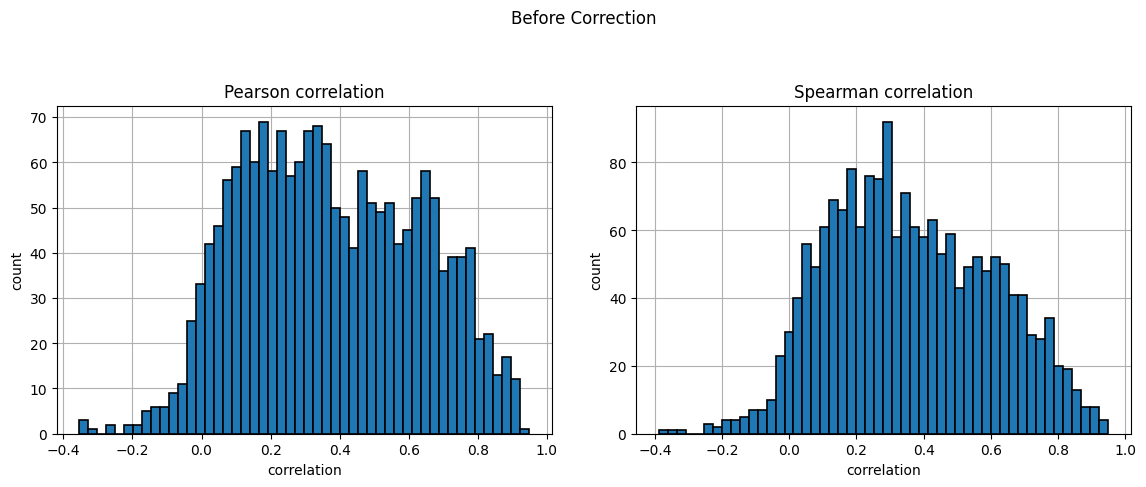

In [21]:
corrs = compute_overlapping_protein_correlation(main_adata.layers["raw"], pilot_adata.layers["raw"])

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
fig.suptitle("Before Correction")
fig.tight_layout(pad=3)

ax = axes[0]
ax.hist(corrs["pearson"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation")
ax.set_xlabel("correlation")
ax.set_ylabel("count")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(corrs["spearman"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation")
ax.set_xlabel("correlation")
ax.set_ylabel("count")
ax.grid(True)
ax.set_axisbelow(True)

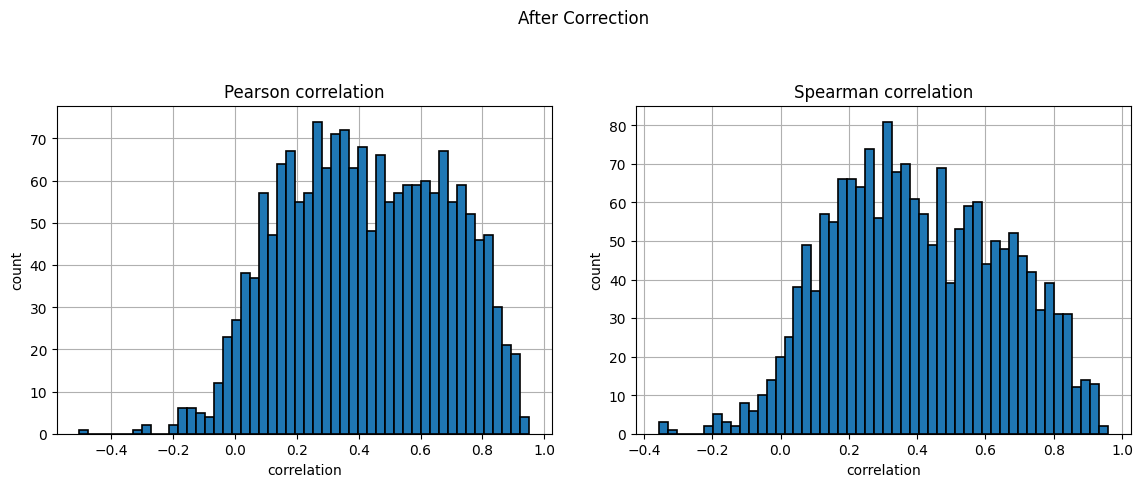

In [22]:
corrs = compute_overlapping_protein_correlation(main_adata.layers["corrected"], pilot_adata.layers["corrected"])

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
fig.suptitle("After Correction")
fig.tight_layout(pad=3)

ax = axes[0]
ax.hist(corrs["pearson"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation")
ax.set_xlabel("correlation")
ax.set_ylabel("count")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(corrs["spearman"], bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation")
ax.set_xlabel("correlation")
ax.set_ylabel("count")
ax.grid(True)
ax.set_axisbelow(True)

### RLE plots

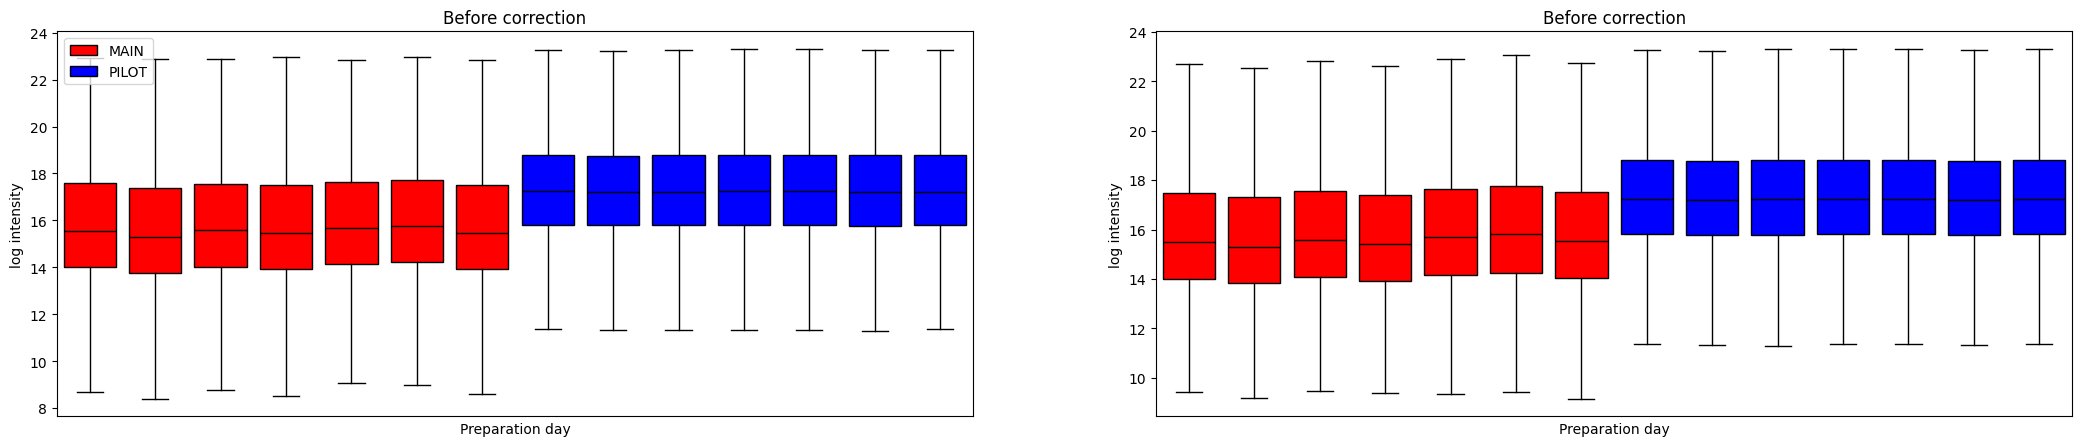

In [23]:
category = "Preparation day" # "Plate"
categories = np.unique(main_adata.obs[category].values)

fig, axes = plt.subplots(figsize=(26, 5), ncols=2)

# Before correction
ax = axes[0]
ax.set_xlabel(f"{category}")
ax.set_ylabel("log intensity")
ax.set_title("Before correction")
ax.axes.set_xlim(-0.5, -0.5 + 2*categories.size)

main_adata.X = main_adata.layers["raw"]
pilot_adata.X = pilot_adata.layers["raw"]

for i, c in enumerate(categories):
    adata_c = main_adata[main_adata.obs[category].values == c]
    v = adata_c.X.flatten()
    v = v[~np.isnan(v)]
    ax.boxplot(v, positions=[i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(color="black"))

position_offset = categories.size
for i, c in enumerate(categories):
    adata_c = pilot_adata[main_adata.obs[category].values == c]
    v = adata_c.X.flatten()
    v = v[~np.isnan(v)]
    ax.boxplot(v, positions=[i + position_offset], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="blue"), medianprops=dict(color="black"))

# After correction
ax = axes[1]
ax.set_xlabel(f"{category}")
ax.set_ylabel("log intensity")
ax.set_title("Before correction")
ax.axes.set_xlim(-0.5, -0.5 + 2*categories.size)

main_adata.X = main_adata.layers["corrected"]
pilot_adata.X = pilot_adata.layers["corrected"]

for i, c in enumerate(categories):
    adata_c = main_adata[main_adata.obs[category].values == c]
    v = adata_c.X.flatten()
    v = v[~np.isnan(v)]
    ax.boxplot(v, positions=[i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(color="black"))

position_offset = categories.size
for i, c in enumerate(categories):
    adata_c = pilot_adata[main_adata.obs[category].values == c]
    v = adata_c.X.flatten()
    v = v[~np.isnan(v)]
    ax.boxplot(v, positions=[i + position_offset], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="blue"), medianprops=dict(color="black"))

# legend
from matplotlib.patches import Patch

for ax in axes:
    ax.xaxis.set_ticklabels([])
    ax.set_xticks([])

legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='MAIN'),
    Patch(facecolor='blue', edgecolor='black', label='PILOT'),
]

axes[0].legend(handles=legend_elements, loc="upper left")